# GAN for Patterns of Nature

Train a GAN to generate images of patterns found in nature.

In [1]:
# import
import tensorflow as tf
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import paths
import math
import time

/home/kwan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from simpledatasetloader import SimpleDatasetLoader

## Dataset

Dataset was scraped from Google Images under the query of 'nature patterns'. The Google Chrome Fatkun Batch Image Download extension was used. Downloaded images can be gound in `nature_patterns_images` directory.

### Preprocess - resize
Preprocess image dataset by resizing all images to the same size.

In [3]:
# image_dir = "dataset/nature_patterns_images/"
# save_dir = 'dataset/resized/'

# for item in os.listdir(image_dir):
#     filepath = os.path.join(image_dir, item)
#     if os.path.isfile(filepath):
#         im = Image.open(filepath).convert('RGB')
#         f, e = os.path.splitext(os.path.basename(filepath))
        
#         imResize = im.resize((200, 200), Image.ANTIALIAS)
#         save_path = os.path.join(save_dir, f + '.jpg')
#         imResize.save(save_path, 'JPEG', quality=90)

### Load and prepare dataset

In [4]:
dataset = 'dataset/resized/'
imagePaths = list(paths.list_images(dataset))

trainImages = np.empty([len(imagePaths), 200, 200, 3])

# load images into numpy array
for i in range(len(imagePaths)):
    im = Image.open(imagePaths[i])
    np_im = np.asarray(im)
    trainImages[i] = np_im

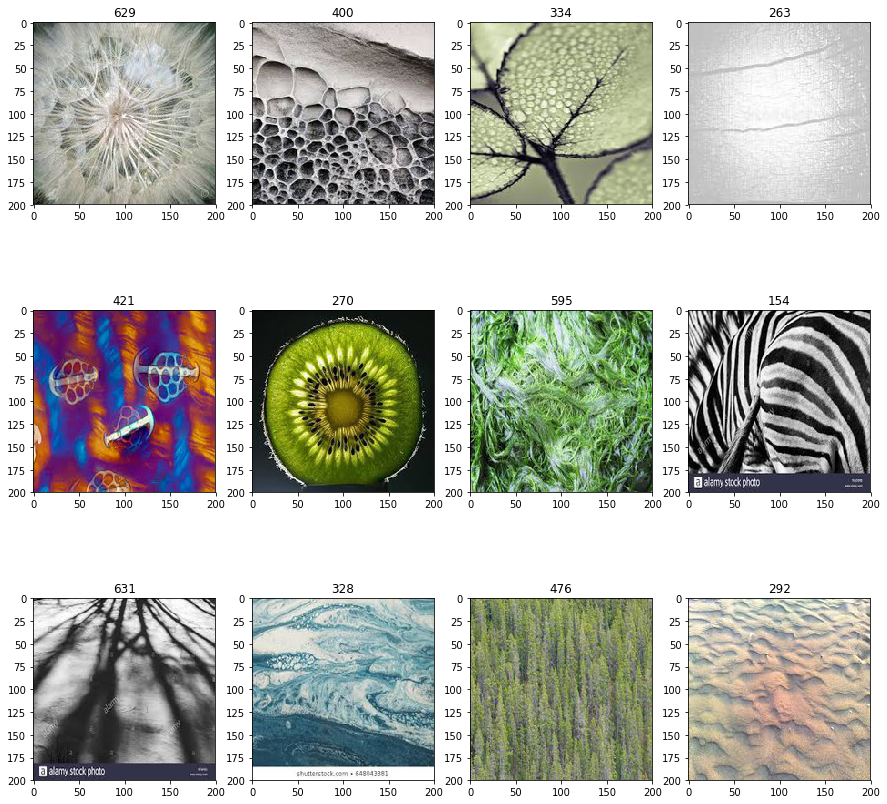

In [5]:
# preview images
preview_n = 12
previews = np.random.choice(len(trainImages), preview_n)

fig = plt.figure(figsize=(15,15))
columns = 4
rows = math.ceil(preview_n/columns)

for i in range(1, preview_n + 1):
    np_im_preview = trainImages[previews[i-1]]
    im_preview = Image.fromarray((np_im_preview).astype(np.uint8))
    fig.add_subplot(rows, columns, i).set_title(previews[i-1])
    plt.imshow(im_preview)

In [6]:
# normalize images
trainImages = trainImages.reshape(trainImages.shape[0], 200, 200, 3).astype('float32')
trainImages = (trainImages - 127.5) / 127.5

In [7]:
BUFFER_SIZE = len(imagePaths)
BATCH_SIZE = 32

In [8]:
# batch and shuffle data
train_dataset = tf.data.Dataset.from_tensor_slices(trainImages).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Modeling

We will use the Keras Sequential API to define the generator and the discriminator.

### Generator

The generator creates an image from random noise.


In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

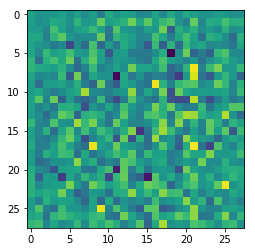

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

### Discriminator

The discriminator is pretty much a CNN image classifier. The job of the discriminator is to check if the image created by the generator can pass as a real image. Thus, can the generated image pass as an image for a pattern of nature?

In [23]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[200, 200, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [24]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


InvalidArgumentError: input depth must be evenly divisible by filter depth: 1 vs 3 [Op:Conv2D]

### Loss and Optimizers

Define loss functions and optimizers for both generator and discriminator models.

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


#### Discriminator loss
This loss function quantifies the discriminator's ability to distinguish real and fake images.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator loss
The generator's loss function quantifies how well it was able to trick the discriminator. If it is able to trick the discriminator, the fake images will be classified as real (1). 

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Training definitions

The discriminator and generator are two separate networks, so two different optimizers are needed.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Checkpoints

Save training checkpoints.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training loop


In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


### Generate and save image

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


## Model training

In [22]:
train(train_dataset, EPOCHS)


ValueError: in converted code:

    <ipython-input-19-ae02327b3832>:10 train_step  *
        real_output = discriminator(images, training=True)
    /home/kwan/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:812 __call__
        self.name)
    /home/kwan/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/input_spec.py:213 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [256, 200, 200, 3]
